In [47]:
import pandas as pd
import numpy as np


N = 50000

z = np.random.uniform(-1, 1, size=N)
u = np.random.normal(1, size=N)
z_0 = 0.

p_x =  (z < z_0) / (1. + np.exp(-z + u)) + \
      (z >= z_0) / (1. + np.exp(-z + u - 0.5))
x = np.random.binomial(1, p=p_x)

epsilon = 0.1*np.random.normal(size=N)
y = u*x + epsilon
y0 = epsilon
y1 = u + epsilon

df = pd.DataFrame({'X': x, 'Z': z, 'Y': y, 'Y1': y1, 'Y0': y0})

## Is the data biased? The true ATE averages 1, since the individual effect is just U.

In [48]:
df.groupby('X').mean()['Y'][1] - df.groupby('X').mean()['Y'][0]

0.514894370481035

so we have bias around -0.5

# Let's examine our assumptions.

1. There is a discontinuity, $$lim_{z \rightarrow z_0^+ } P(X|Z=z) \neq lim_{z \rightarrow z_0^- } P(X|Z=z)$$
2. The counterfactuals are continuous at the discontinuity
3. $\tau \perp X | Z = z_0$

## 1. How does P(X|Z) look at the discontinuity?

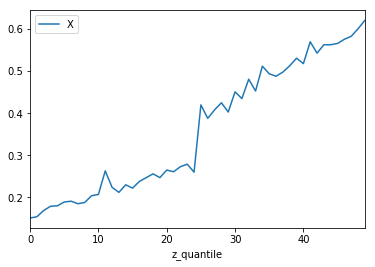

In [49]:
df['z_quantile'] = pd.qcut(df['Z'], 50, range(50))
df.groupby('z_quantile').mean().plot(y='X')

So we see there's a jump discontinuity, and can confirm assumption 1.

## 2. The counterfactuals are continuous at $Z=Z_0$ 

We can't confirm this directly, since we can't measure the counterfactuals for everyone! 

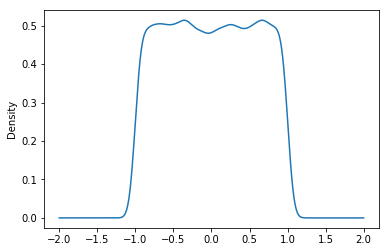

In [50]:
df.Z.plot.kde()

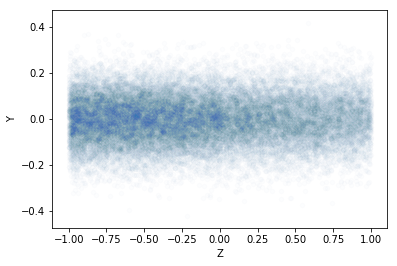

In [24]:
df[df.X==0].plot(x='Z', y='Y', kind='scatter', alpha=0.01)

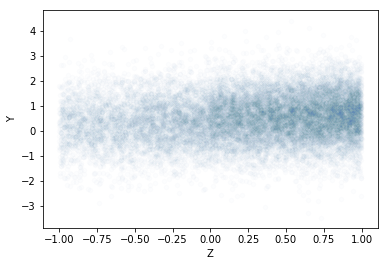

In [25]:
df[df.X==1].plot(x='Z', y='Y', kind='scatter', alpha=0.01)

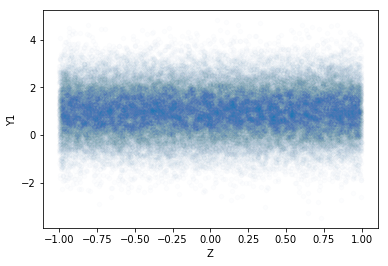

In [26]:
df.plot(x='Z', y='Y1', kind='scatter', alpha=0.01)

In [51]:
from sklearn.neighbors import RadiusNeighborsRegressor


model_left = RadiusNeighborsRegressor(radius=0.1)
model_left = model_left.fit(df[df.Z < z_0][['Z']], df[df.Z < z_0]['Y'])

model_right = RadiusNeighborsRegressor(radius=0.1)
model_right = model_right.fit(df[df.Z >= z_0][['Z']], df[df.Z >= z_0]['Y'])

def predict_y(z):
    if z < z_0:
        return model_left.predict([[z]])[0]
    else:
        return model_right.predict([[z]])[0]

df['y_pred'] = df['Z'].apply(predict_y)

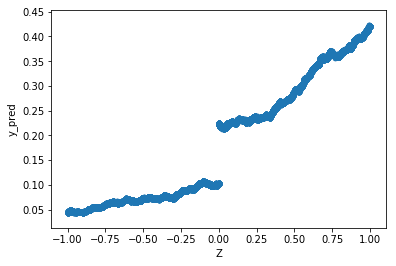

In [52]:
df.plot(x='Z', y='y_pred', kind='scatter')

In [54]:
dy = model_right.predict([[z_0]])[0] - model_left.predict([[z_0]])[0]
dy

0.12193115285074034

In [38]:
from sklearn.neighbors import RadiusNeighborsRegressor


model_left = RadiusNeighborsRegressor(radius=0.1)
model_left = model_left.fit(df[df.Z < z_0][['Z']], df[df.Z < z_0]['Y1'])

model_right = RadiusNeighborsRegressor(radius=0.1)
model_right = model_right.fit(df[df.Z >= z_0][['Z']], df[df.Z >= z_0]['Y1'])

def predict_y(z):
    if z < z_0:
        return model_left.predict([[z]])[0]
    else:
        return model_right.predict([[z]])[0]

df['y_pred'] = df['Z'].apply(predict_y)

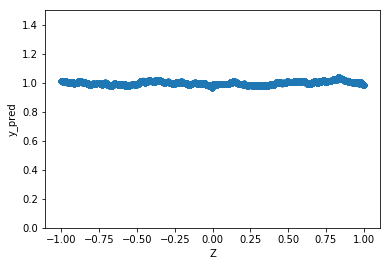

In [39]:
df.plot(x='Z', y='y_pred', kind='scatter', ylim=(0,1.5))

In [55]:
from sklearn.neighbors import RadiusNeighborsRegressor


model_left = RadiusNeighborsRegressor(radius=0.1)
model_left = model_left.fit(df[df.Z < z_0][['Z']], df[df.Z < z_0]['X'])

model_right = RadiusNeighborsRegressor(radius=0.1)
model_right = model_right.fit(df[df.Z >= z_0][['Z']], df[df.Z >= z_0]['X'])

def predict_y(z):
    if z < z_0:
        return model_left.predict([[z]])[0]
    else:
        return model_right.predict([[z]])[0]

df['x_pred'] = df['Z'].apply(predict_y)

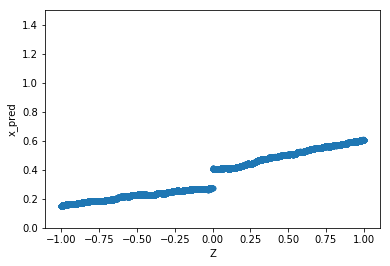

In [56]:
df.plot(x='Z', y='x_pred', kind='scatter', ylim=(0,1.5))

In [57]:
dx = model_right.predict([[z_0]])[0] - model_left.predict([[z_0]])[0]
dx

0.1340401088720533

In [58]:
dy / dx

0.9096616966129784